In [29]:
import sys
sys.path.append("..")

import pandas as pd
from mlops.model_training.model_validation import CombPurgedKFoldCV

In [30]:
df_train = pd.read_csv('/home/sam/github/finance-data-driven/data/processed/synthetic_ticker_data.csv')

n_splits=6
n_test_splits=2
time_gap = 100
embargo_td = 2

cpkf = CombPurgedKFoldCV(n_splits=n_splits, n_test_splits=n_test_splits, embargo_td=embargo_td)

t1_ = df_train.index
t1 = pd.Series(t1_).shift(time_gap).fillna(0).astype(int)
t2 = pd.Series(t1_).shift(-time_gap).fillna(1e12).astype(int)

splits = list(cpkf.split(df_train, pred_times=t1, eval_times=t2))

In [31]:
cols_feat = [c for c in df_train.columns if c not in ['datetime', 'target','ticker']]

In [32]:
col_target = "target"

In [33]:
from sklearn.datasets import make_classification
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, StratifiedKFold
import pandas as pd
import mlflow
import yaml
import optuna
from dotenv import load_dotenv
load_dotenv()
# Function to initialize model
def init_model(model_type, params):
    if model_type == 'xgboost':
        return XGBClassifier(**params)
    elif model_type == 'random_forest':
        return RandomForestClassifier(**params)
    else:
        raise ValueError("Invalid model_type")
# Objective function for Optuna
def objective(trial, model_type, X_train, y_train, X_val, y_val):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 2, 32),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000)
    }
    model = init_model(model_type, params)
    model.fit(X_train, y_train)
    return model.score(X_val, y_val)  # or any other metric
def train_and_log_model(model_type, X_train, y_train, X_val, y_val):
    study = optuna.create_study(direction='maximize')
    study.optimize(lambda trial: objective(trial, model_type, X_train, y_train, X_val, y_val), n_trials=50)
    
    best_params = study.best_params
    mlflow.log_params(best_params)
    
    model = init_model(model_type, best_params)
    model.fit(X_train, y_train)
    
    mlflow.sklearn.log_model(model, f"{model_type}_model")
try:
    with open("../config/train_config.yaml", 'r') as f:
        config = yaml.safe_load(f)
except FileNotFoundError:
    print("Configuration file not found. Exiting.")
    exit()

# Sample dataset
X, y = make_classification()
df = pd.DataFrame(X, columns=[f"feature_{i}" for i in range(X.shape[1])])
df['target'] = y

cv_method = config.get('validation_method', 'kfold')
if cv_method == 'kfold':
    cv = KFold(n_splits=5)
elif cv_method == 'stratified_kfold':
    cv = StratifiedKFold(n_splits=5)

# Training and evaluation
with mlflow.start_run() as run:
    for train_idx, val_idx in cv.split(df.drop(columns=['target']), df['target']):
        X_train, y_train = df.iloc[train_idx].drop(columns=['target']), df.iloc[train_idx]['target']
        X_val, y_val = df.iloc[val_idx].drop(columns=['target']), df.iloc[val_idx]['target']
        
        if 'xgboost' in config:
            train_and_log_model('xgboost', X_train, y_train, X_val, y_val)
        
        if 'random_forest' in config:
            train_and_log_model('random_forest', X_train, y_train, X_val, y_val)

print("Models trained and logged.")

True

[I 2023-10-03 23:57:44,943] A new study created in memory with name: no-name-2c1557e5-4278-4dc4-89ea-81d092e6ec04
/home/sam/miniconda3/envs/training/lib/python3.10/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/sam/miniconda3/envs/training/lib/python3.10/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/home/sam/miniconda3/envs/training/lib/python3.10/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/home/sam/miniconda3/envs/training/lib/python3.10/site-packages/xgboost/data.py:359: FutureWarnin

TypeError: RandomForestClassifier.__init__() got an unexpected keyword argument 'learning_rate'

[I 2023-10-03 23:24:51,875] A new study created in memory with name: no-name-2812fed6-9346-44cd-816b-8a85f0dfb564
/home/sam/miniconda3/envs/training/lib/python3.10/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/sam/miniconda3/envs/training/lib/python3.10/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/home/sam/miniconda3/envs/training/lib/python3.10/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/home/sam/miniconda3/envs/training/lib/python3.10/site-packages/xgboost/data.py:359: FutureWarnin

KeyboardInterrupt: 

In [ ]:
for fold, (folds_train_set_index, fold_val_set_index) in enumerate(splits):
    X_train = df_train.loc[folds_train_set_index, cols_feat]
    y_train = df_train.loc[folds_train_set_index, col_target]

    X_val = df_train.loc[fold_val_set_index, cols_feat]
    y_val = df_train.loc[fold_val_set_index, col_target]

/tmp/ipykernel_56066/3005209260.py:25: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


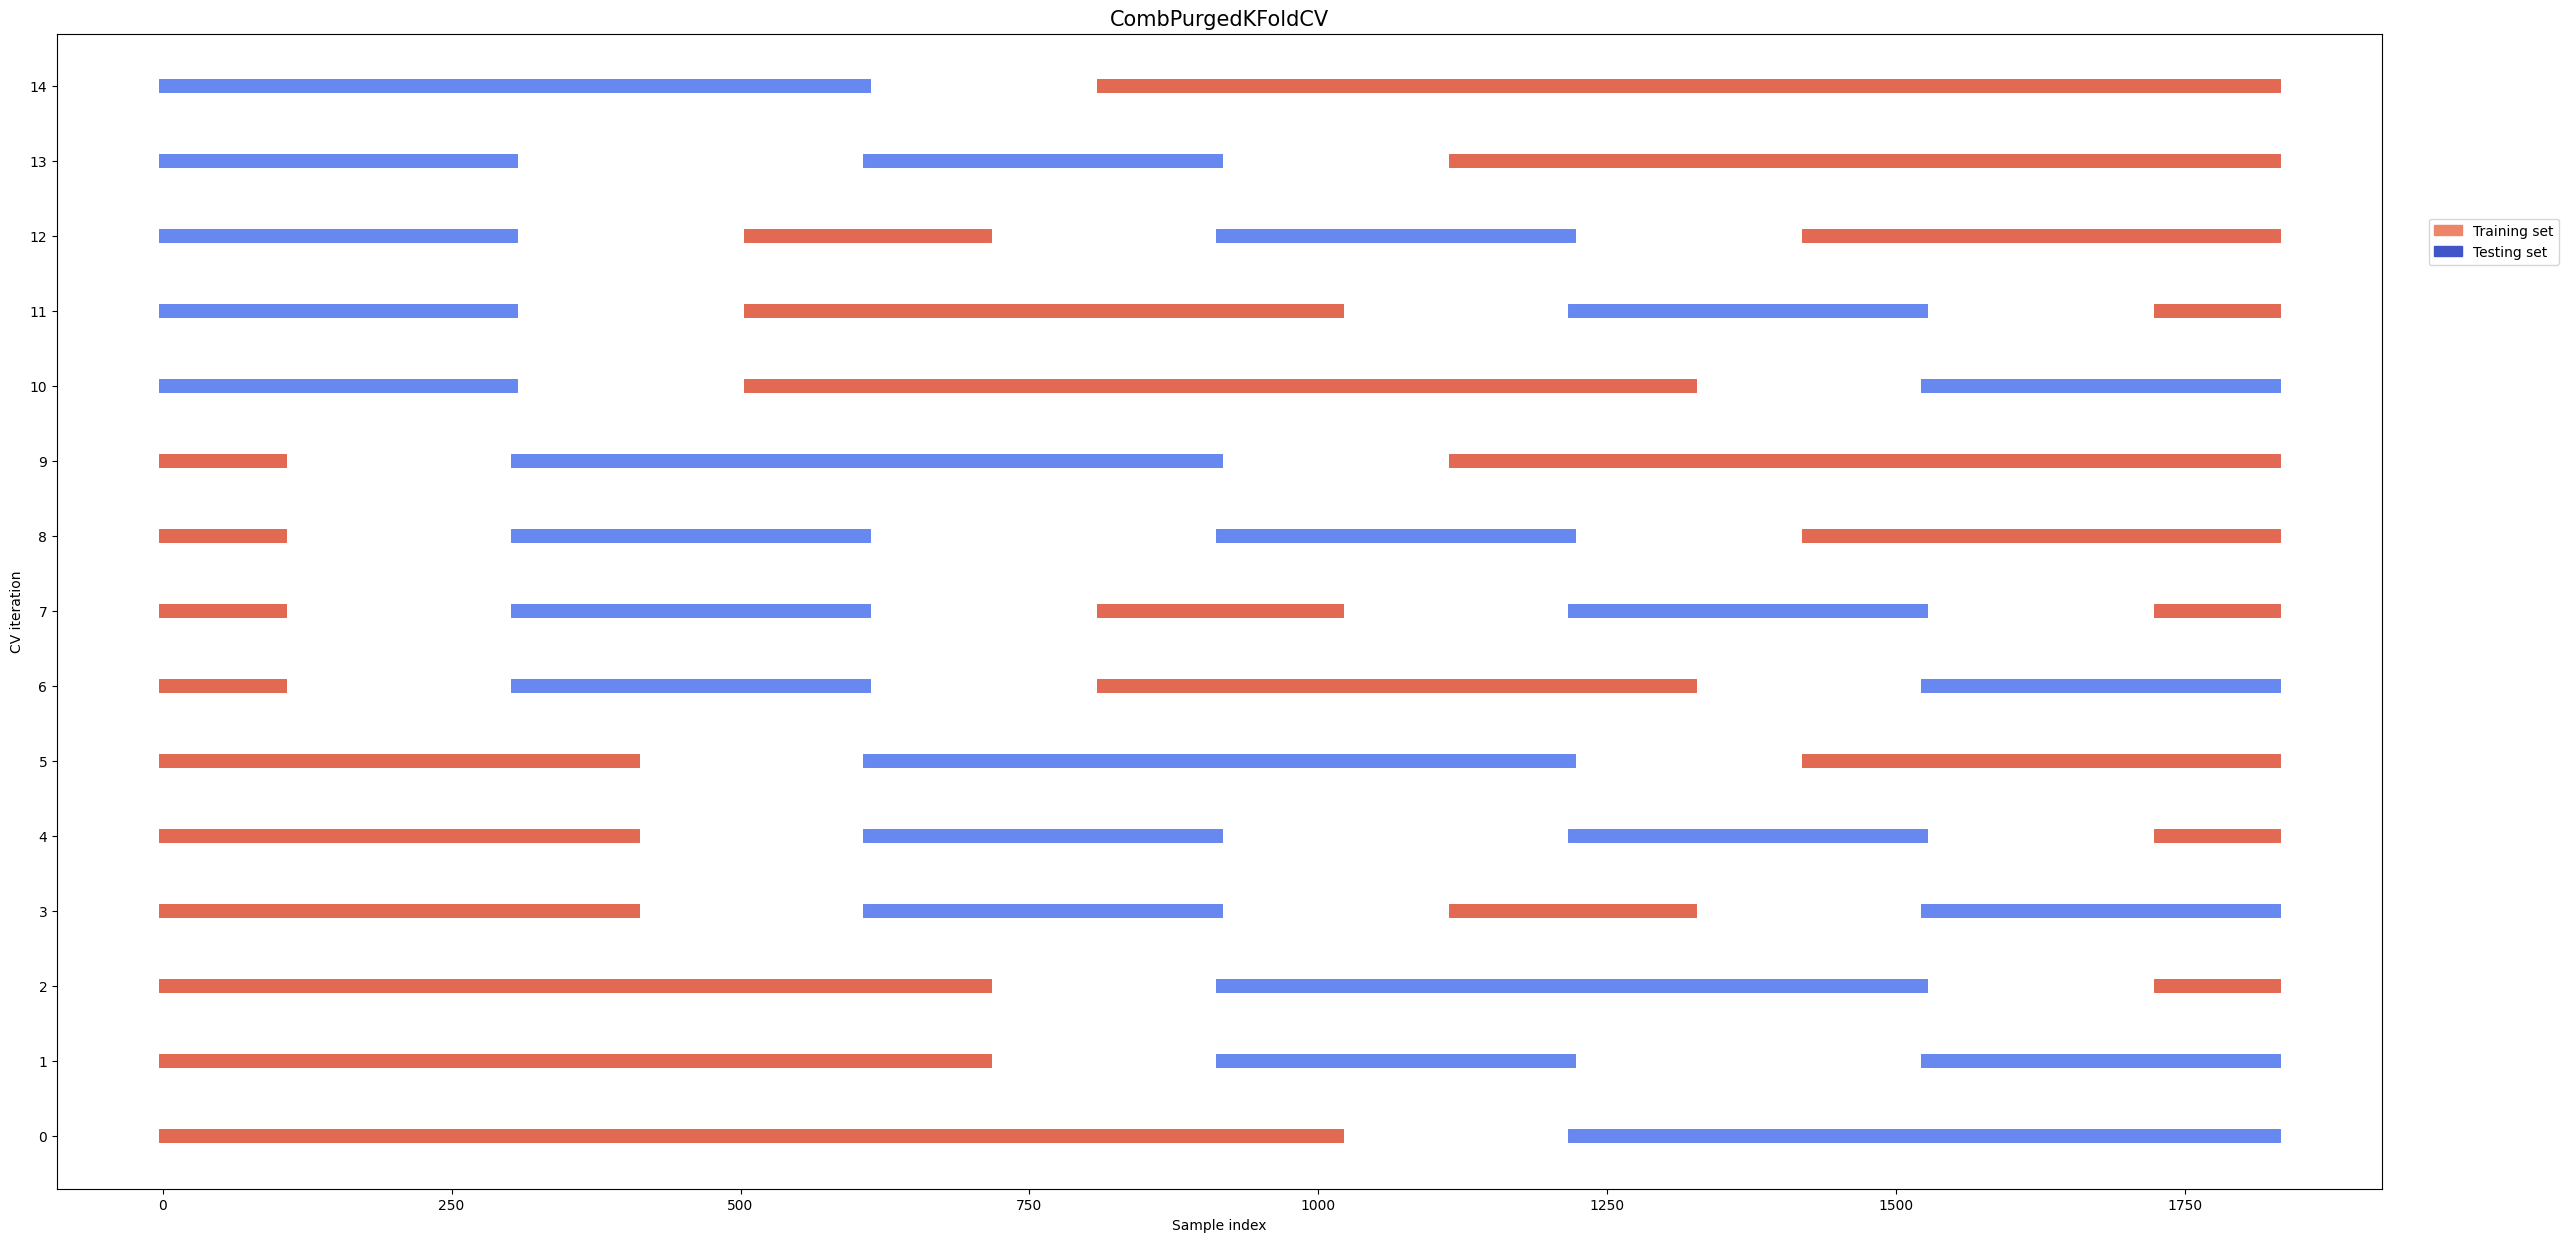

In [10]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm

fig = plt.figure(figsize=(30,15))
ax = fig.add_subplot(111)

for ii, split in enumerate(splits):  
    indices = np.array([np.nan] * len(dtrain.iloc[:10000]))
    indices[split[0]] = 1
    indices[split[1]] = 0

    ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                       c=indices, marker='_', lw=10, cmap=cmap_cv,
                       vmin=-.2, vmax=1.2)

yticklabels = list(range(len(splits)))

ax.set(yticks=np.arange(len(splits)) + .5, yticklabels=yticklabels, xlabel='Sample index', ylabel="CV iteration")
ax.set_title('CombPurgedKFoldCV', fontsize=15)

ax.legend([Patch(color=cmap_cv(.8)), Patch(color=cmap_cv(.02))], ['Training set', 'Testing set'], loc=(1.02, .8))

fig.show()